In [1]:
import pandas as pd
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.cross_validation import train_test_split#, cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [7]:
churn_d = pd.read_csv("G:\megogo\churn_model\churn_model.csv", sep = ",")
churn_d.head(n=10)

,user_id,promo_ind,is_auto_prolong,num_operations,duration,operation_BY_TOKEN,operation_REGULAR,churn
0,6,0,0,11,3.3,0,1,0
1,7,0,0,10,59.7,0,1,0
2,10,0,0,7,1.8,0,1,0
3,14,0,1,3,349.6,0,0,0
4,40,0,0,6,20.5,0,1,0
5,72,0,0,6,7.9,0,1,0
6,212,0,0,2,118.4,1,0,0
7,266,0,0,1,25.0,1,0,1
8,446,0,1,1,78.2,0,1,0
9,524,0,1,2,211.4,0,0,0


In [6]:
print(churn_d['churn'].value_counts())

0    51488
1    33844
Name: churn, dtype: int64


In [8]:
x_train, x_test, y_train, y_test = train_test_split(churn_d.ix[:, ~churn_d.columns.isin(['user_id', 'churn'])], churn_d['churn'])

In [16]:
#Logistic Regression
pipeline_log =  Pipeline([('clf', LogisticRegression())])
parameters_log = {'clf__penalty': ('l1', 'l2'),
                  'clf__C': (0.01, 0.1, 1, 10),
                  'clf__fit_intercept': (True, False)}

#Decision Tree                  
pipeline_tree = Pipeline([
                          ('clf', DecisionTreeClassifier(criterion='entropy'))
                          ])
parameters_tree = {
                   'clf__max_depth': (150, 155, 160),
                   'clf__min_samples_split': (1, 2, 3),
                   'clf__min_samples_leaf': (1, 2, 3)}

#Random Forest                   
pipeline_forest = Pipeline([
                            ('clf', RandomForestClassifier(criterion='entropy'))
                            ])
parameters_forest = {
                     'clf__n_estimators': (5, 10, 20, 50),
                     'clf__max_depth': (50, 150, 250),
                     'clf__min_samples_split': (1, 2, 3),
                     'clf__min_samples_leaf': (1, 2, 3)}
                     
result = pd.DataFrame()

model_data =    [
                {'name': 'Logistic Regression',
                 'pipeline': pipeline_log,
                 'parameters': parameters_log,
                 'color': 'g'},
                 
                {'name': 'Decision Tree',
                 'pipeline': pipeline_tree,
                 'parameters': parameters_tree,
                 'color': 'r'},
                 
                 {'name': 'Random Forest',
                 'pipeline': pipeline_forest,
                 'parameters': parameters_forest,
                 'color': 'b'}
                 ]

In [17]:
for model in model_data:                 
    grid_search = GridSearchCV(model['pipeline'], model['parameters'], n_jobs = -1, verbose = 0, scoring = 'f1')
    grid_search.fit(x_train, y_train)
    predictions = grid_search.predict(x_test)

    #roc curve
    predictions_prob = grid_search.predict_proba(x_test)
    false_positive_rate, recall, thresholds = roc_curve(y_test, predictions_prob[:,1])
    roc_auc = auc(false_positive_rate, recall)
    plt.plot(false_positive_rate, recall, model['color'], label = 'AUC %s = %0.2f' % (model['name'], roc_auc))
    plt.plot([0,1], [0,1], 'r--')
    plt.legend(loc = 'lower right')
    plt.ylabel('Recall')
    plt.xlabel('Fall-out')
    plt.title('ROC Curve')
    temp = pd.DataFrame({'1.Best grid search score': grid_search.best_score_,
                         '2.Accuracy': accuracy_score(y_test, predictions),
                         '3.Precision': precision_score(y_test, predictions),
                         '4.Recall': recall_score(y_test, predictions),
                         '6.AUC': roc_auc,
                         '5.F1': f1_score(y_test, predictions)
                         }, index = [model['name']])
    result = result.append(temp)

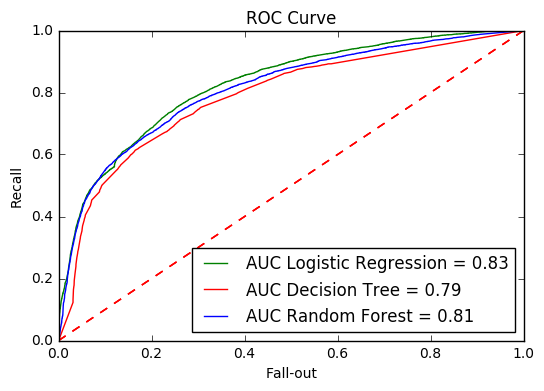

In [18]:
plt.show()

In [19]:
result

,1.Best grid search score,2.Accuracy,3.Precision,4.Recall,5.F1,6.AUC
Logistic Regression,0.656817,0.760090,0.755589,0.585918,0.660024,0.826004
Decision Tree,0.652152,0.745371,0.703106,0.622007,0.660075,0.786926
Random Forest,0.673073,0.755027,0.716491,0.634863,0.673212,0.811612
